# 3.11 模型选择、欠拟合和过拟合
## 3.11.4 多项式函数拟合实验

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

1.3.1


### 3.11.4.1 生成数据集

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
#cat((tensor1,tensor2,..),dim)按照dim进行拼接，0为行，1为列
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
#噪声项服从均值为0、标准差为0.01的正态分布
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 1.6966],
         [-0.3173]]),
 tensor([[ 1.6966,  2.8786,  4.8839],
         [-0.3173,  0.1007, -0.0319]]),
 tensor([24.5821,  4.0993]))

### 3.11.4.2 定义、训练和测试模型

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

### 3.11.4.3 三阶多项式函数拟合（正常）

final epoch: train loss 0.00089659244986251 test loss 0.0002534413943067193
weight: tensor([[ 1.1989, -3.3994,  5.5956]]) 
bias: tensor([4.9985])


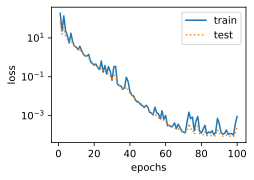

In [7]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

### 3.11.4.4 线性函数拟合（欠拟合）

final epoch: train loss 407.3572998046875 test loss 120.73841094970703
weight: tensor([[21.5202]]) 
bias: tensor([2.0310])


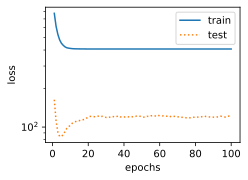

In [6]:
#根据第二维的大小决定网络的结构，即w的维度
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

### 3.11.4.5 训练样本不足（过拟合）

final epoch: train loss 0.7242816686630249 test loss 97.84769439697266
weight: tensor([[0.0608, 2.4016, 3.0336]]) 
bias: tensor([2.7703])


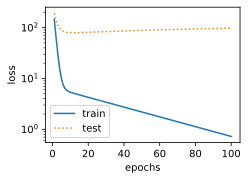

In [8]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])